# Parameter Inference and Calibration

*Setup from @rmaria del rio-chanona et al. 2021*
*Code: @ebbamark


In [1]:
# Import packages
from abm_funs import *
import os
import pyabc
import csv
import tempfile
import statistics
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from pyabc.visualization import plot_kde_matrix
import math as math
from statistics import mode
from pyabc.transition import MultivariateNormalTransition
import seaborn as sns
from IPython import display
from pstats import SortKey
from matplotlib.backends.backend_pdf import PdfPages
rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/"

hello - new import works!


## Update for Maria

Hi Maria!

The following is my first attempt/current status of the parameter inference/calibration work. In brief, this notebook uses the pyabc package to approach parameter inference/calibration via sequential Monte Carlo approximate Bayesian computation (SMCABC/ABC). Trial-and-error led me to in this first instance of progress sharing to look at calibrating the two "deltas" (spontaneous vacancy creation and separation parameters) in line with real-world unemployment and vacancy rates. Throughout this notebook, I comment the various choices made and data sources incorporated. Nothing is final of course (as you will see) and a lot would benefit from a second look or pointers from you when you have the time :) 
 
#### Summary:

*The main successes until this point:*

- **Get pyabc to run/work:** Run pyabc on both delta_u and delta_v (spontaneous separation and vacancy rates) calibrated to match the mean unemployment rate and job openings rates reported in the most recent non-recession period (2010-2019) by the US Bureau of Labor Statistics (BLS) and Job Openings and Labour Turnover Survey (JOLTS). Please note that what I refer to as the "vacancy rate" throughout this notebook is actually the "job openings rate" which is not the correct value to calibrate to (perhaps this is where the Lightcast data could be used?). Rather, the job openings rate is more the direct comparison for the delta itself...this should be corrected in the next step. 

- **Include macro and JOLTS data:** Incorporated data from both the JOLTS to use to set suitable priors for each delta__ as well as from the BLS on UER, vacancy rates, and GDP. 

- **Incorporated real business cycle length:** Each time step in our model corresponds to a month and I've expanded our sinusoidal business cycle dynamic to reflect the length of the most recent real-world pre-Covid business cycle with the epxansion period running from January 2010-December 2019. The total length from peak-to-peak of this most recent business cycle is difficult to distinguish given Covid hits at its near-end but it is roughly 13 years or 160 months long. This follows the business cycle dating of the NBER: https://www.nber.org/research/business-cycle-dating. Recession periods are shown in gray bars in the following plots. 

- **Preliminary calibration of spontaneous vacancy and separations rates:** I have calibrated the deltas to the MEAN of the UER and vacancy (job openings...) rates during this period but not to second moment conditions (variance) although this can be done once we have checked in (want to make sure that I am on the right track before going further). 


*Question/issues up until this point:*

- **Suitable ABC rejection conditions:** I don't have a lot of experience with Bayesian methods in general - although this is a fairly intuitive application so I think I've understood most of what is going on. However, the trial-and-error work so far required restricting various parameters of the ABC method (population size/number of accepted simulations, number of iterations in which the acceptance threshold is decreased) to help with implementation. I will need to be more robust in choice of population size and epsilon acceptance threshold once we move toward the "final"/reportable calibration. Indeed, these shortcuts likely contribute to why the "calibration" has not yet yielded the most useful results as you'll see.
- **Matching full business cycle:** Matching to the expansion period of the business cycle made sense in a first step but it would be best to calibrate to the full business cycle. One of the limitations here is that the business cycle is asymmetric (expansion periods are long, contraction/recession periods are shorter). 


*Next steps:*
- Match additional moments of the UER and vacancy rates (at least variance)
- Calibrate to real vacancy rate (not substituted job openings rate as done below)
- Adjust conditions of ABC for more precise parameter inference
- Calibrate additional parameters (ex. gamma/adjustment time of the economy to changes in target demand - this will likely help triangulate the amplitude of the business cycle as well). 
- Match full business cycle. In the case of unemployment rate, the reaction of unemployment rate to changes in the business cycle is asymmetric - UER increase quickly in recession period but declines slowly in expansion periods - see Figure 3 below).
- One idea that you (Maria) had suggested in a recent discussion was to link the behaviour of the unemployment rate to GDP - this could aid in the business cycle matching (see prelim data in Figure 4 - GDP will need to be detrended). 


Note: All hand-written functions called in the below script are recorded in abm_funs.py to ease reading.


### Data

#### US Model
Model constructed using 464 occupations from US Bureau of Labor Statistics (BLS) Data and IPUMS.
Data input from replication code in dRC et al 2021: https://zenodo.org/records/4453162. This data should be re-extracted. Perhaps incorporate econometric testing for transition probability/matrix calculations.

Additionally includes data on the gender share per occupation also from the BLS.

In [2]:
###################################
# US MODEL CONDITIONS AND DATA ####
###################################


# Set preliminary parameters for delta_u, delta_v, and gamma 
# - these reproduce nice Beveridge curves but were arrived at non-systematically
del_u = 0.015
del_v = 0.009
behav_spec = False
gamma_u = gamma_v = gamma = 0.1

A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

print(mod_data['employment'].sum() + mod_data['unemployment'].sum())


IPUMS_CPS_av_monthly_employment_whole_period    14673.0
dtype: float64


### Initialise Network

In [3]:
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 3)

Done after  300  time steps.
Done after  300  time steps.


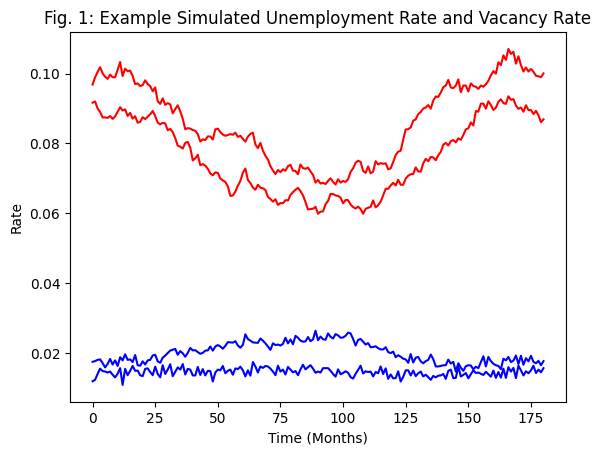

In [4]:
# The following are the input data to the function that runs the model. Perhaps not an appropriately named dictionary
# as only a few of the dictionary elements are parameters. 

parameter = {'mod_data': mod_data, # mod_data: occupation-level input data
    # (ie. employment/uneployment levels, wages, gender ratio, etc.).
     # net_temp: occupational network
     'net_temp': net_temp,
     # list of available vacancies in the economy
     'vacs': vacs, 
     # whether or not to enable behavioural element or not (boolean value)
     'behav_spec': behav_spec,
     # number of time steps to iterate the model - for now always exclude ~50 time steps for the model to reach a steady-state
     'time_steps': 300,
     # del_u: spontaneous separation rate
     'd_u': del_u,
     # del_v: spontaneous vacancy rate
     'd_v': del_v,
     # gamma: "speed" of adjustment to target demand of vacancies and unemployment
     'gamma': gamma,
     # bus_cycle_len: length of typical business cycle (160 months as explained above)
     'bus_cycle_len': 160,
     # delay: number of time steps to exclude from calibration sample to allow model 
     # to reach steady state and expansion phase of business cycle - this is certainly inefficient and should be changed.
     'delay': 120}


# The following line runs one base example of the model itself with the parameters outlined above. 
# This demonstrates the issue I mention above about needing time to achieve a "steady-state" from the initialised state of about 50 time steps.
# Run model without behavioural spec
rec = run_single(**parameter)

parameter.update({'behav_spec': True,
                   'd_u': 0.016,
                   'd_v': 0.01,
                   'gamma': 0.13})

rec_behav = run_single(**parameter)

plt.plot(rec['UER'], color = "red")
plt.plot(rec['VACRATE'], color = "blue")
plt.plot(rec_behav['UER'], color = "red")
plt.plot(rec_behav['VACRATE'], color = "blue")
plt.title("Fig. 1: Example Simulated Unemployment Rate and Vacancy Rate")
plt.ylabel("Rate")
plt.xlabel("Time (Months)")
plt.show()


## Parameter inference

### Observed Values/Data

Reference values for the various calibration steps are loaded and plotted below for reference. Thus far, I have included variables from the JOLTS (total nonfarm job openings rate, separation rate, quits rate, hires rate - all in seasonally adjusted monthly values). Additionally, I include the seasonally adjusted monthly unemployment rate and quarterly real GDP (although the latter has not been used yet in this script). 

Recession dates are downloaded from FRED but sourced from NBER business cycle indicators mentioned above. For each time series, I include the source URL. 

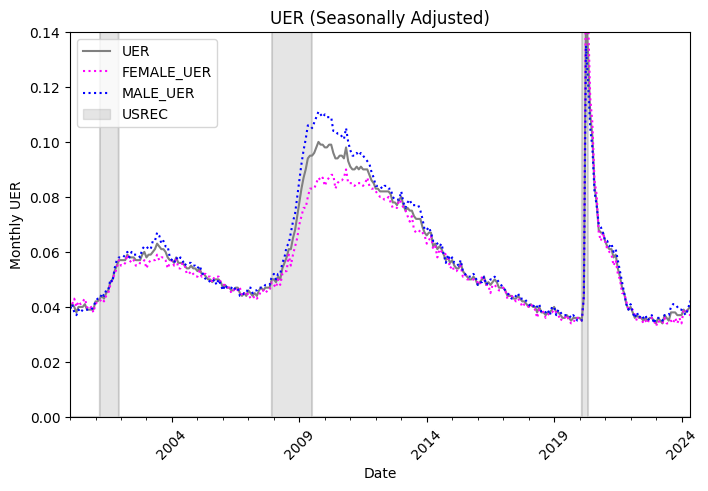

In [5]:
# Observed unemployment rate
# Monthly, seasonally adjusted
# Source: https://fred.stlouisfed.org/series/UNRATE

unrate = pd.read_csv(path+"data/macro_vars/UNRATE.csv", delimiter=',', decimal='.')
unrate["DATE"] = pd.to_datetime(unrate["DATE"])
unrate["UER"] = unrate['UNRATE']/100
unrate['FD_UNRATE'] = pd.Series(unrate['UER']).diff()

# Monthly, seasonally adjusted job openings rate (total nonfarm)
# Source: https://fred.stlouisfed.org/series/JTSJOR

jorate = pd.read_csv(path+"data/macro_vars/JTSJOR.csv", delimiter=',', decimal='.')
jorate["DATE"] = pd.to_datetime(jorate["DATE"])
jorate["VACRATE"] = jorate['JTSJOR']/100
jorate['FD_VACRATE'] = pd.Series(jorate['VACRATE']).diff()

macro_observations = pd.merge(unrate, jorate, how = 'outer', on = 'DATE')

# Recession dates
# Source: https://fred.stlouisfed.org/series/USREC#:%7E:text=For%20daily%20data%2C%20the%20recession,the%20month%20of%20the%20trough

recessions = pd.read_csv(path+"data/macro_vars/USREC.csv", delimiter=',', decimal='.')
recessions["DATE"] = pd.to_datetime(recessions["DATE"])

# Real GDP
# Source: https://fred.stlouisfed.org/series/GDPC1
realgdp = pd.read_csv(path+"data/macro_vars/GDPC1.csv", delimiter=',', decimal='.')
realgdp["DATE"] = pd.to_datetime(realgdp["DATE"])
realgdp["REALGDP"] = realgdp['GDPC1']
realgdp['FD_REALGDP'] = pd.Series(realgdp['REALGDP']).diff()

macro_observations = pd.merge(macro_observations, realgdp, how = 'outer', on = 'DATE')

# Female unemployment rate
# https://fred.stlouisfed.org/series/LNS14000002
f_unrate = pd.read_csv(path+"data/macro_vars/LNS14000002.csv", delimiter=',', decimal='.')
f_unrate["DATE"] = pd.to_datetime(f_unrate["DATE"])
f_unrate["FEMALE_UER"] = f_unrate['LNS14000002']/100
f_unrate['FD_FEMALE_UER'] = pd.Series(f_unrate['FEMALE_UER']).diff()

# Male unemployment rate
# https://fred.stlouisfed.org/series/LNS14000001
m_unrate = pd.read_csv(path+"data/macro_vars/LNS14000001.csv", delimiter=',', decimal='.')
m_unrate["DATE"] = pd.to_datetime(m_unrate["DATE"])
m_unrate["MALE_UER"] = m_unrate['LNS14000001']/100
m_unrate['FD_MALE_UER'] = pd.Series(m_unrate['MALE_UER']).diff()

macro_observations = pd.merge(macro_observations, f_unrate, how = 'outer', on = 'DATE')
macro_observations = pd.merge(macro_observations, m_unrate, how = 'outer', on = 'DATE')

# Job openings (levels - thousands)
# Source: https://fred.stlouisfed.org/series/JTSJOL
jobopenings = pd.read_csv(path+"data/macro_vars/JTSJOL.csv", delimiter=',', decimal='.')
jobopenings["DATE"] = pd.to_datetime(jobopenings["DATE"])
jobopenings["JOBOPENINGS"] = jobopenings['JTSJOL']
jobopenings['FD_JOBOPENINGS'] = pd.Series(jobopenings['JOBOPENINGS']).diff()

# Employment (total non-farm) (levels - thousands)
# Source: https://fred.stlouisfed.org/series/PAYEMS
emp_real = pd.read_csv(path+"data/macro_vars/PAYEMS.csv", delimiter=',', decimal='.')
emp_real["DATE"] = pd.to_datetime(emp_real["DATE"])
emp_real["EMPLOYMENT"] = emp_real['PAYEMS']
emp_real['FD_EMPLOYMENT'] = pd.Series(emp_real['EMPLOYMENT']).diff()

t_demand_real = pd.merge(jobopenings, emp_real, how = 'outer', on = 'DATE')
t_demand_real['TARGET_DEMAND'] = t_demand_real['JOBOPENINGS'] + t_demand_real['EMPLOYMENT']

fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "grey")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'FEMALE_UER', color = "magenta", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'MALE_UER', color = "blue", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

plt.xlim("2000-01-01", "2024-05-01")
plt.ylim(0, 0.14)

# Add title and axis labels
plt.title('UER (Seasonally Adjusted)')
plt.xlabel('Date')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()


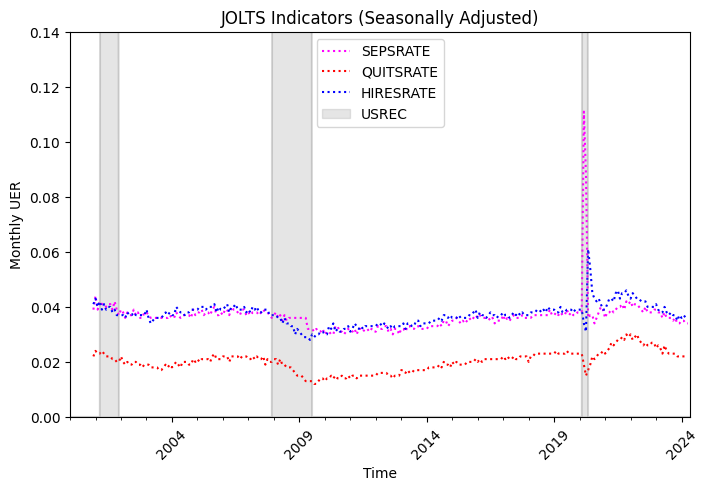

In [6]:
## JOLTS SURVEY: https://www.bls.gov/charts/job-openings-and-labor-turnover/hire-seps-rates.htm

# Separation rates (Total nonfarm): JOLTS Survey - monthly, seasonally adjusted
# Source: https://fred.stlouisfed.org/series/JTSTSR
seps = pd.read_csv(path+"data/macro_vars/JTSTSR.csv", delimiter=',', decimal='.')
seps["DATE"] = pd.to_datetime(seps["DATE"])
seps["SEPSRATE"] = seps['JTSTSR']/100
seps['FD_SEPSRATE'] = pd.Series(seps['SEPSRATE']).diff()

# Quits rate (Total nonfarm): JOLTS Survey - monthly, seasonally adjusted
# Source: https://fred.stlouisfed.org/series/JTSQUR
quits = pd.read_csv(path+"data/macro_vars/JTSQUR.csv", delimiter=',', decimal='.')
quits["DATE"] = pd.to_datetime(quits["DATE"])
quits["QUITSRATE"] = quits['JTSQUR']/100
quits['FD_QUITSRATE'] = pd.Series(quits['QUITSRATE']).diff()

jolts = pd.merge(quits, seps, how = 'left', on = 'DATE')

# Hires rate (Total nonfarm): JOLTS Survey - monthly, seasonally adjusted
# Source: https://fred.stlouisfed.org/series/JTSHIR
hires = pd.read_csv(path+"data/macro_vars/JTSHIR.csv", delimiter=',', decimal='.')
hires["DATE"] = pd.to_datetime(hires["DATE"])
hires["HIRESRATE"] = hires['JTSHIR']/100
hires['FD_HIRESRATE'] = pd.Series(hires['HIRESRATE']).diff()

jolts = pd.merge(jolts, hires, how = 'left', on = 'DATE')

fig, ax = plt.subplots()
jolts.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'SEPSRATE', color = "magenta", linestyle = "dotted")
jolts.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'QUITSRATE', color = "red", linestyle = "dotted")
jolts.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'HIRESRATE', color = "blue", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

plt.xlim("2000-01-01", "2024-05-01")
plt.ylim(0, 0.14)

# Add title and axis labels
plt.title('JOLTS Indicators (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()

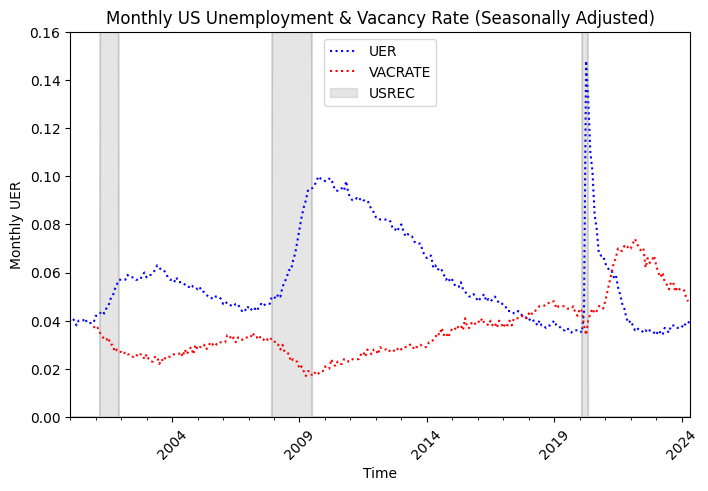

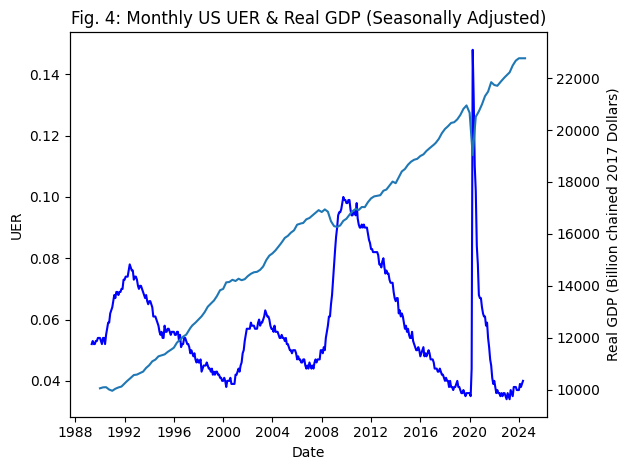

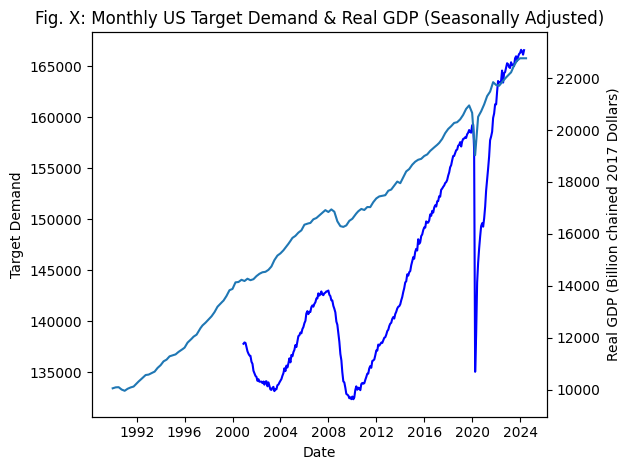

In [7]:
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

plt.xlim("2000-01-01", "2024-05-01")
plt.ylim(0, 0.16)

# Add title and axis labels
plt.title('Monthly US Unemployment & Vacancy Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

### UER AND REAL GDP
ax1.set_xlabel('Date')
ax1.set_ylabel('UER')
ax1.plot(macro_observations['DATE'], macro_observations['UER'], color="blue")
#ax1.set_xlim("2000-01-01", "2024-05-01")
#ax1.area(recessions, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_ylabel('Real GDP (Billion chained 2017 Dollars)')  # we already handled the x-label with ax1
ax2.plot(macro_observations['DATE'], (macro_observations.interpolate())['REALGDP'])
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(macro_observations['REALGDP'].min()-1000, macro_observations['REALGDP'].max() + 1000)

# Add title and axis labels
plt.title('Fig. 4: Monthly US UER & Real GDP (Seasonally Adjusted)')
plt.xticks(rotation=45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

### UER AND REAL GDP
ax1.set_xlabel('Date')
ax1.set_ylabel('Target Demand')
ax1.plot(t_demand_real['DATE'], t_demand_real['TARGET_DEMAND'], color="blue")
#ax1.set_xlim("2000-01-01", "2024-05-01")
#ax1.area(recessions, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

ax2.set_ylabel('Real GDP (Billion chained 2017 Dollars)')  # we already handled the x-label with ax1
ax2.plot(macro_observations['DATE'], (macro_observations.interpolate())['REALGDP'])
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(macro_observations['REALGDP'].min()-1000, macro_observations['REALGDP'].max() + 1000)

# Add title and axis labels
plt.title('Fig. X: Monthly US Target Demand & Real GDP (Seasonally Adjusted)')
plt.xticks(rotation=45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


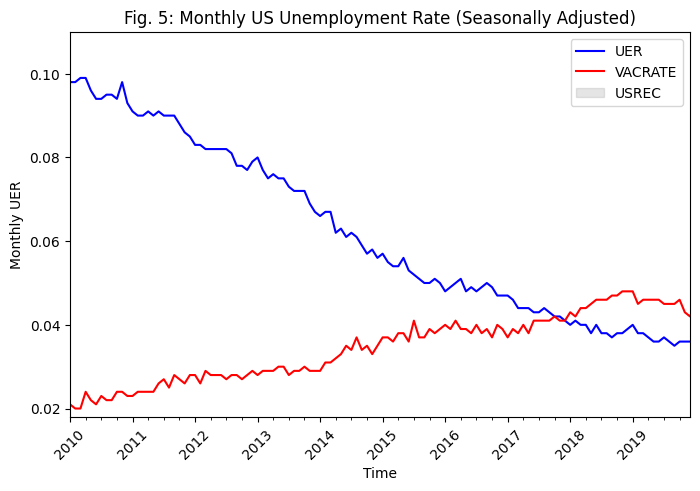

In [8]:

# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)

plt.xlim("2010-01-01", "2019-12-01")
plt.ylim(0.018, 0.11)

# Add title and axis labels
plt.title('Fig. 5: Monthly US Unemployment Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()



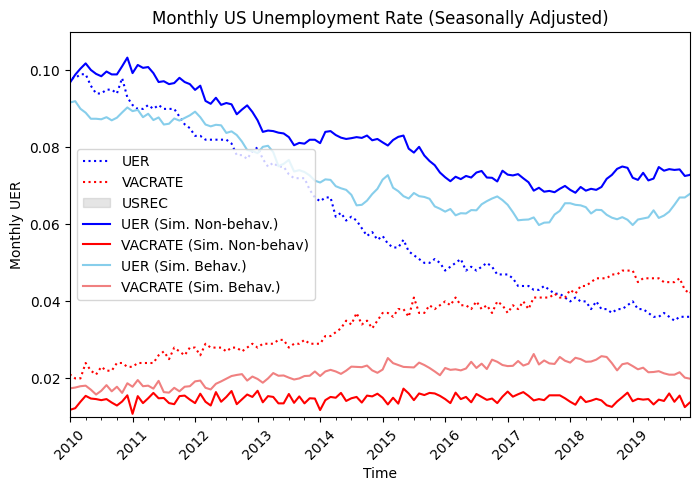

In [9]:

# Incorporating one set of simulated data
sim_data = pd.DataFrame(rec)
sim_data['PROV DATE'] = pd.date_range(start = "2010-01-01", periods = len(sim_data), freq = "ME")
sim_data['FD_SIMUER'] = pd.Series(sim_data['UER']).diff()
sim_data['FD_SIMVACRATE'] = pd.Series(sim_data['VACRATE']).diff()

sim_data_behav = pd.DataFrame(rec_behav)
sim_data_behav['PROV DATE'] = pd.date_range(start = "2010-01-01", periods = len(sim_data_behav), freq = "ME")
sim_data_behav['FD_SIMUER'] = pd.Series(sim_data_behav['UER']).diff()
sim_data_behav['FD_SIMVACRATE'] = pd.Series(sim_data_behav['VACRATE']).diff()

# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "blue", label = "UER (Sim. Non-behav.)")
sim_data.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "red", label = "VACRATE (Sim. Non-behav)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'UER', color = "skyblue", label = "UER (Sim. Behav.)")
sim_data_behav.plot.line(ax = ax, x = 'PROV DATE', y = 'VACRATE', color = "lightcoral", label = "VACRATE (Sim. Behav.)")

plt.xlim("2010-01-01", "2019-12-01")
plt.ylim(0.01, 0.11)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()





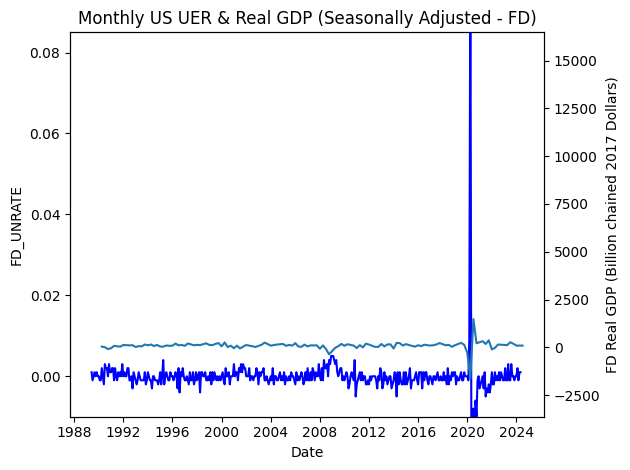

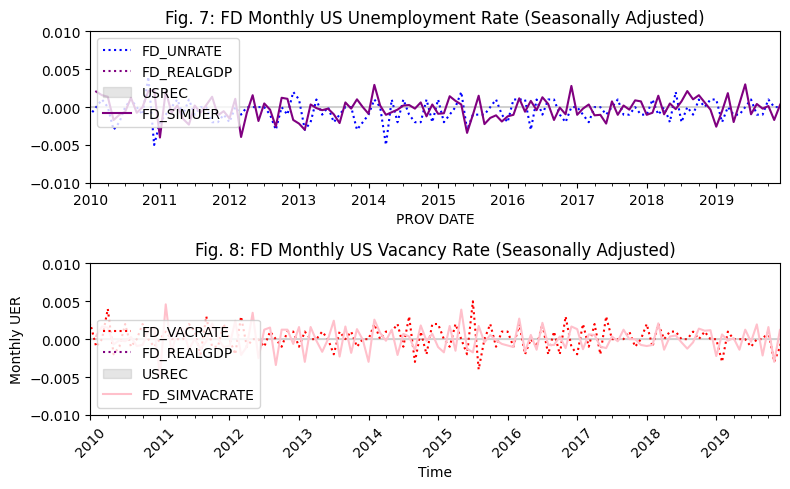

In [10]:

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

### UER AND REAL GDP
ax1.set_xlabel('Date')
ax1.set_ylabel('FD_UNRATE')
ax1.plot(macro_observations['DATE'], macro_observations['FD_UNRATE'], color="blue")
#ax1.set_xlim("2000-01-01", "2024-05-01")
#ax1.area(recessions, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
ax1.set_ylim(-0.01, 0.085)

ax2.set_ylabel('FD Real GDP (Billion chained 2017 Dollars)')  # we already handled the x-label with ax1
ax2.plot(macro_observations['DATE'], (macro_observations.interpolate())['FD_REALGDP'])
#ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(macro_observations['FD_REALGDP'].min()-2000, macro_observations['FD_REALGDP'].max() + 15000)

# Add title and axis labels
plt.title('Monthly US UER & Real GDP (Seasonally Adjusted - FD)')
plt.xticks(rotation=45)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# FIRST DIFFERENCES
# I wanted to look at the values in first-differences to see a de-trended version of the data. 
# These first-differences are not yet used anywhere else in the script. 
# Non-recession period
fig, (ax1, ax2) = plt.subplots(2)
macro_observations.plot.line(ax = ax1, figsize = (8,5), x= 'DATE', y = 'FD_UNRATE', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax2, figsize = (8,5), x= 'DATE', y = 'FD_VACRATE', color = "red", linestyle = "dotted")
macro_observations.plot.line(ax = ax1, figsize = (8,5), x= 'DATE', y = 'FD_REALGDP', color = "purple", linestyle = "dotted")
macro_observations.plot.line(ax = ax2, figsize = (8,5), x= 'DATE', y = 'FD_REALGDP', color = "purple", linestyle = "dotted")
recessions.plot.area(ax = ax1, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
recessions.plot.area(ax = ax2, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
sim_data.plot.line(ax = ax1, x = 'PROV DATE', y = 'FD_SIMUER', color = "purple")
sim_data.plot.line(ax = ax2, x = 'PROV DATE', y = 'FD_SIMVACRATE', color = "pink")

ax1.set_xlim("2010-01-01", "2019-12-01")
ax1.set_ylim(-0.01, 0.01)
ax2.set_xlim("2010-01-01", "2019-12-01")
ax2.set_ylim(-0.01, 0.01)

# Add title and axis labels
ax1.set_title('Fig. 7: FD Monthly US Unemployment Rate (Seasonally Adjusted)')
ax2.set_title('Fig. 8: FD Monthly US Vacancy Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)
fig.tight_layout()

# Display the plot
plt.show()



## Multiple Parameter Inference

### Deltas

Originally, I started by trying to just triangulate a single delta (delta_u to match UER) but it is important that they are both tested jointly as they interact (duh...but, hey, it's a learning process :) ). So in the following I test the joint parameter space of delta_u and delta_v with a preset gamma/economy's adjustment propensity (although ideally gamma should be tested in line with the relationship between UER and GDP when we incorporate this relationship as well as all three being used to match the typical amplitude of a business cycle). I would also imagine that the gammas should be different for vacancies and unemployment rates.

In [15]:
def pyabc_run_single(paramater):     
    res = run_single(**parameter)
    return res 

parameter = {'mod_data': mod_data,
          'net_temp': net_temp,
          'vacs': vacs, 
          'behav_spec': behav_spec,
          'time_steps': 220,
          'd_u': del_u,
          'd_v': del_v,
          'gamma': gamma,
          'bus_cycle_len': 160,
          'delay': 120}

# Proposed priors for d_u and d_v taken from the separations and 
# job openings rates modelled in the first few plots of this notebook
# These priors can of course be more carefully selected calculating directly from those rates....next steps
prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.001, 0.1),
                          d_v = pyabc.RV("uniform", 0.001, 0.1),
                          gamma = pyabc.RV("uniform", 0.05, 0.2))

# distance function jointly minimises distance between simulated 
# mean of UER and vacancy rates to real-world UER and vacancy rates
def distance_mean(x, y):
    diff_uer = (x["UER"].mean(axis = 0)) - ((y["data"]["UER"]).mean(axis=0))
    diff_vac = (x["VACRATE"].mean(axis = 0)) - ((y["data"]["VACRATE"]).mean(axis=0))
    dist_mean = np.sqrt(diff_uer**2 + diff_vac**2)
    print(dist_mean)
    return dist_mean

def distance(x, y):
    diff_uer = np.sum((x["UER"][0:100] - y["UER"])**2)
    diff_vac = np.sum((x["VACRATE"][0:100] - y["VACRATE"])**2)
    dist = np.sqrt(diff_uer + diff_vac)
    return dist

calib_sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs = 2)
abc = pyabc.ABCSMC(pyabc_run_single, prior, distance, population_size = 20, sampler = calib_sampler)

db_path = os.path.join(tempfile.gettempdir(), "test.db")

# The following creates the "reference" values from the observed data - I pull the non-recession or expansion period from 2010-2019.
observation = macro_observations.loc[(macro_observations['DATE'] >= '2010-01-01') & (macro_observations['DATE'] <= "2019-12-01")].reset_index()
buffer = int((len(observation) - parameter['time_steps'])/2)
obs_abbrev = (observation[buffer + (int(parameter['delay']/2)):(buffer + parameter['time_steps']) - int((parameter['delay']/2))]).reset_index()
data = {'UER': np.array(obs_abbrev['UER']),
        'VACRATE': np.array(obs_abbrev['VACRATE'])}

abc.new("sqlite:///" + db_path, data)

history = abc.run(minimum_epsilon=0.2, max_nr_populations=3)

ABC.Sampler INFO: Parallelize sampling on 2 processes.
ABC.History INFO: Start <ABCSMC id=11, start_time=2024-09-27 14:30:04>
ABC INFO: Calibration sample t = -1.
ABC.History INFO: Done <ABCSMC id=11, duration=0:00:04.317560, end_time=2024-09-27 14:30:09>


KeyboardInterrupt: 

Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.
Done after  220  time steps.


### Preliminary Results
Neither delta is very well identified, which I assume has to do with the choice population size and only performing 2 adjustements of the prior. Next steps...

array([[<Axes: ylabel='d_u'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='d_v'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='d_u', ylabel='gamma'>, <Axes: xlabel='d_v'>,
        <Axes: xlabel='gamma'>]], dtype=object)

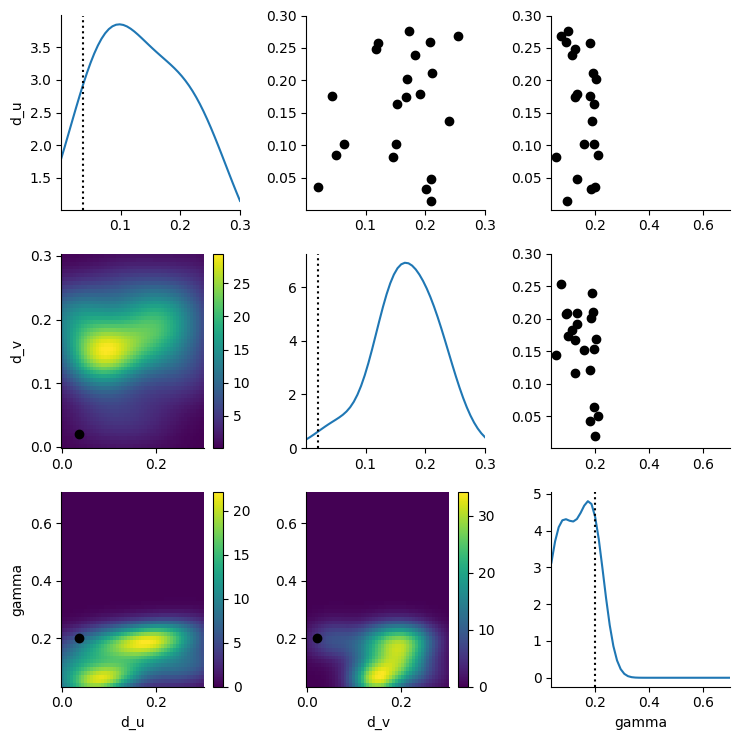

In [12]:

gt = {"d_u": jolts['SEPSRATE'].mean(axis = 0), "d_v": jolts['QUITSRATE'].mean(axis = 0), "gamma": 0.2}

df, w = history.get_distribution()
#scipy.describe(df['d_u'])

plot_kde_matrix(
    df,
    w,
    limits={"d_u": (0.001, 0.3), "d_v": (0.001, 0.3), "gamma": (0.04, 0.7)},
    refval=gt,
    refval_color='k',
)

Heatmaps of the joint parameter space of the deltas. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


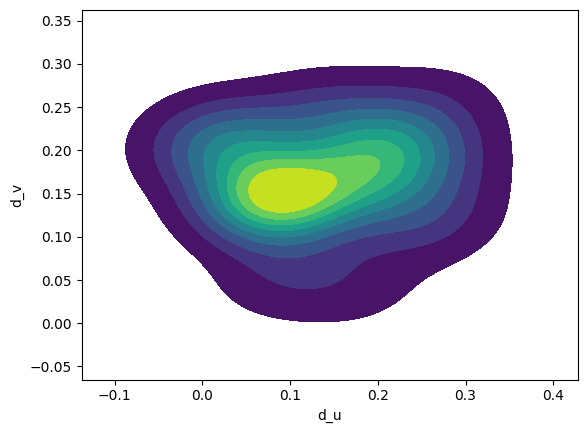

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

Text(0.5, 1.0, 'hello')

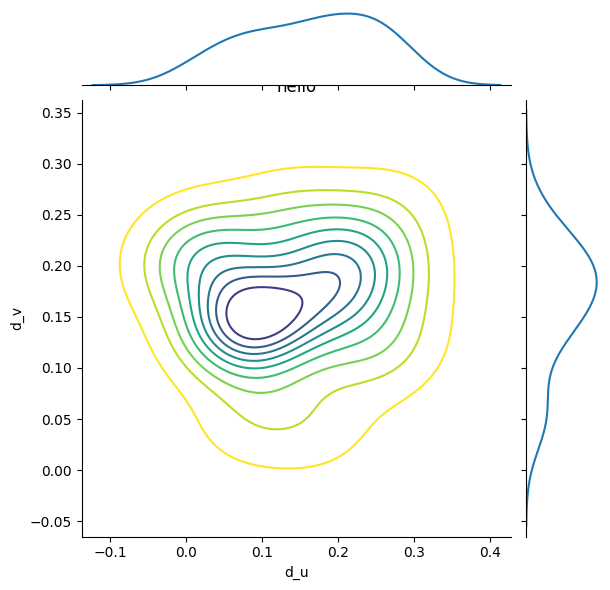

In [13]:
sns.kdeplot(x = "d_u", y = "d_v", data = df, weights = w, cmap = "viridis", fill = True)
#plt.axvline(x = sum(df['d_u']*w))
#plt.axhline(y = sum(df['d_v']*w))
plt.show()

sns.jointplot(x = "d_u", y = "d_v", kind = "kde", data = df, weights = w, cmap = "viridis_r")

plt.title("hello")

The following graphs shows simulation results using parameter combinations sampled from the original prior (worst fit), final posterior (better fit), and accepted parameter combinations from the final posterior distribution which gives the best fit. It seems the prior set is likelly too restrictive as the algorithm has a difficult time arriving at an adequate vacancy rate! To be explored further...The left (right) column shows the results for the UER (Vacancy rate) and the black line in each plot demonstrates the observed data from BLS and JOLTS.

sep_prob above 1 - reset
sep_prob above 1 - reset
Done after  220  time steps.
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - reset
vac_prob above 1 - re

KeyboardInterrupt: 

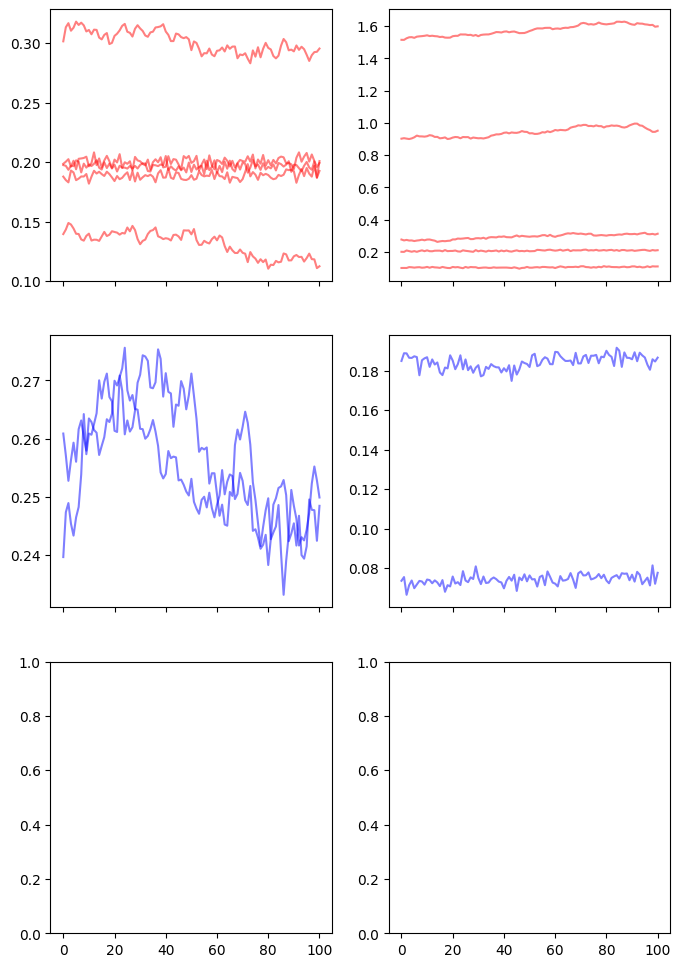

In [14]:
####################################################################################
#### Prior and Posterior Distribution outputs versus Observed UER and Vacancy Rates
fig, axes = plt.subplots(3, 2, sharex=True)
fig.set_size_inches(8, 12)
n = 5  # Number of samples to plot from each category
#Plot samples from the prior
alpha = 0.5
for _ in range(n):
    parameter.update(prior.rvs())
    prior_sample = run_single(**parameter)
    #print(prior_sample)
    axes[0,0].plot(prior_sample["UER"], color="red", alpha=alpha)
    axes[0,1].plot(prior_sample["VACRATE"], color="red", alpha=alpha)

# Fit a posterior KDE and plot samples form it
posterior = MultivariateNormalTransition()
posterior.fit(*history.get_distribution(m=0))

for _ in range(n):
    parameter.update(posterior.rvs())
    posterior_sample = run_single(**parameter)
    axes[1,0].plot(posterior_sample["UER"], color="blue", alpha=alpha)
    axes[1,1].plot(posterior_sample["VACRATE"], color="blue", alpha=alpha)

# Plot the stored summary statistics
sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
for stored in sum_stats[1][:n]:
    axes[2,0].plot(stored["UER"], color="green", alpha=alpha)
    axes[2,1].plot(stored["VACRATE"], color="green", alpha=alpha)

# Plot the observed UER from BLS
for ax in axes[:,0]:
    obs_abbrev.plot(y="UER", ax=ax, color="black", linewidth=1.5)
    ax.legend().set_visible(False)
    ax.set_ylabel("UER")
    
# Plot the observed VACRATE from JOLTS
for ax in axes[:,1]:
    obs_abbrev.plot(y="VACRATE", ax=ax, color="black", linewidth=1.5)
    ax.legend().set_visible(False)
    ax.set_ylabel("VACANCY RATE")
    ax.yaxis.set_label_position("right")

fig.suptitle("Simulation Results using Parameters from Prior (sampled), Posterior (sampled), and Posterior (sampled & accepted)")
# Add a legend with pseudo artists to first plot
fig.legend(
    [
        plt.plot([0], color="red")[0],
        plt.plot([0], color="blue")[0],
        plt.plot([0], color="green")[0],
        plt.plot([0], color="black")[0],
    ],
    ["Prior", "Posterior", "Stored, accepted", "Observation"],
    bbox_to_anchor=(0.5, 0.9),
    loc="lower center",
    ncol=4,
)

In [16]:
# Plot the stored summary statistics
print(sum_stats)
sum_stats[1][1]

distance(sum_stats[1][1], {'data': obs_abbrev})

0.3120123752422569

## Testing Selected Parameters

Below I pull the weighted mean of the posterior. Not sure if this is the correct way to pull the triangulated parameter estimate...? Indeed, the model run with these parameters does not look good and both look lower than represented in the heat/contour maps above. The model results with these parameters look bad both with respect to replicating a Beveridge curve as well as we did earlier with hand-selected estimates (and you'll see by the warnings that the delta_u is likely too high....again, I think that this is becuause of poor choice of arguments to the SMCABC algorithm above. In other words, not quite there...to be improved...but getting closer :) 

In [17]:
d_u_hat = sum(df['d_u']*w)
print("d_u_hat: ", d_u_hat)

d_v_hat = sum(df['d_v']*w)
print("d_v_hat: ", d_v_hat)

gamma_hat = sum(df['gamma']*w)
print("gamma_hat: ", gamma_hat)

d_u_hat:  0.15342949660147784
d_v_hat:  0.158143576665866
gamma_hat:  0.13862252125891547


In [19]:

parameters = {'mod_data': mod_data, 
             'net_temp': net_temp,
              'vacs': vacs, 
              'behav_spec': False,
              'time_steps': 220,
              'runs': 2,
              'd_u': d_u_hat,
              'd_v': d_v_hat,
              'gamma': gamma_hat,
              'bus_cycle_len': 160,
              'bus_amp': 0.02}


sim_record_f_all, net_nonbehav, net_nonbehav_list = run_sim(**parameters)

parameters.update({'behav_spec': True})
sim_record_t_all, net_behav, net_behav_list = run_sim(**parameters)


Run:  0
1.0930423600027632
0


ValueError: p < 0, p > 1 or p is NaN

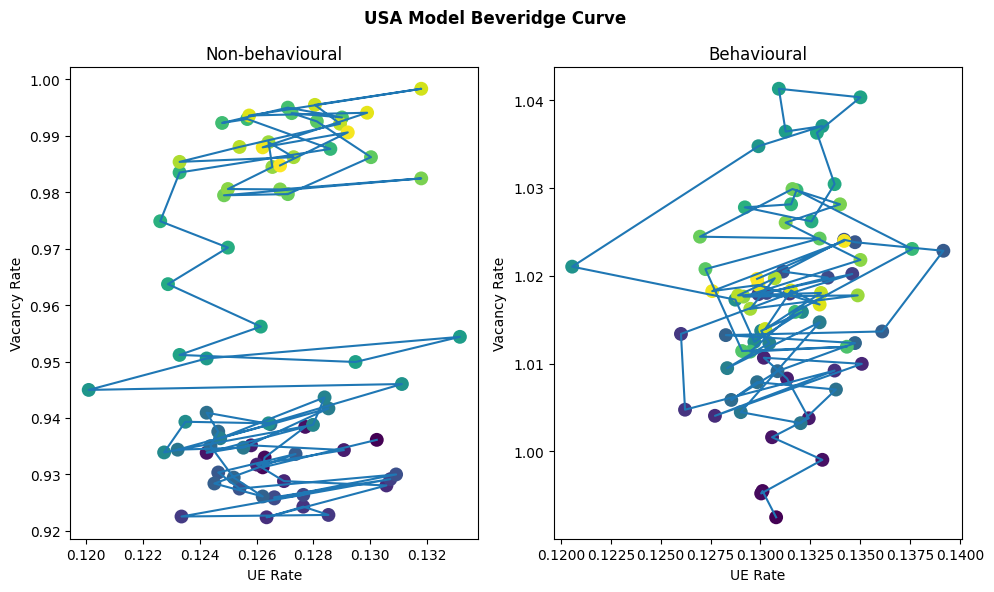

In [19]:
# Summary values for one run 
sim_record_t = pd.DataFrame(np.transpose(np.hstack(sim_record_t_all)))
sim_record_t.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']
sim_record_f = pd.DataFrame(np.transpose(np.hstack(sim_record_f_all)))
sim_record_f.columns =['Sim', 'Time Step', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Target_Demand']

record1_t = sim_record_t[(sim_record_t['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index()
record1_f = sim_record_f[(sim_record_f['Sim'] == 0)].groupby(['Sim', 'Time Step']).sum().reset_index()

end_t = record1_t[(record1_t['Time Step'] == 220)]
end_f = record1_f[(record1_f['Time Step'] == 220)]

ue_vac_f = record1_f.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_f['UE Rate'] = ue_vac_f['Unemployment'] / ue_vac_f['Workers']
ue_vac_f['Vac Rate'] = ue_vac_f['Vacancies'] / ue_vac_f['Target_Demand']
ue_vac_f = ue_vac_f[46:]

ue_vac_t = record1_t.loc[:,['Workers', 'Unemployment', 'Vacancies', 'Target_Demand']]
ue_vac_t['UE Rate'] = ue_vac_t['Unemployment'] / ue_vac_t['Workers']
ue_vac_t['Vac Rate'] = ue_vac_t['Vacancies'] / ue_vac_t['Target_Demand']
ue_vac_t = ue_vac_t[46:]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ue_vac_f = ue_vac_f[100:300]
ue_vac_t = ue_vac_t[100:300]

ax1.plot(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'])
ax1.scatter(ue_vac_f['UE Rate'], ue_vac_f['Vac Rate'], c=ue_vac_f.index, s=100, lw=0)
ax1.set_title("Non-behavioural")
ax1.set_xlabel("UE Rate")
ax1.set_ylabel("Vacancy Rate")

ax2.plot(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'])
ax2.set_title("Behavioural")
ax2.scatter(ue_vac_t['UE Rate'], ue_vac_t['Vac Rate'], c=ue_vac_t.index, s=100, lw=0) 
ax2.set_xlabel("UE Rate")
ax2.set_ylabel("Vacancy Rate")

    
fig.suptitle("USA Model Beveridge Curve", fontweight = 'bold')
fig.tight_layout()


plt.show()
plt.close()

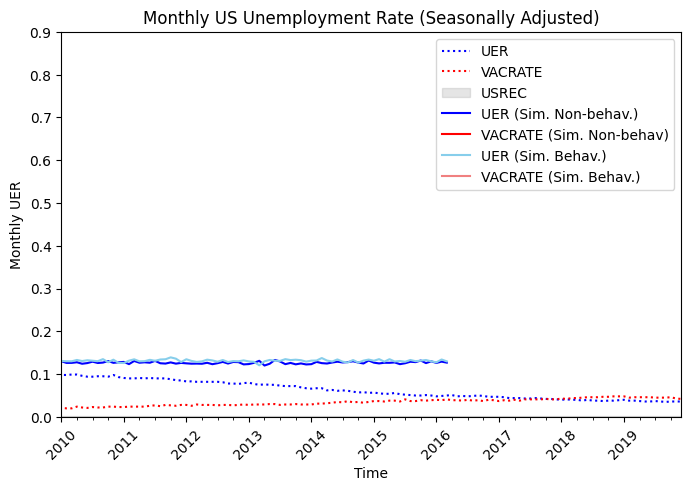

In [20]:
# Incorporating one set of simulated data
ue_vac_f['PROV DATE'] = pd.date_range(start = "2010-01-01", periods = len(ue_vac_f), freq = "ME")
ue_vac_f['FD_SIMUER'] = pd.Series(ue_vac_f['UE Rate']).diff()
ue_vac_f['FD_SIMVACRATE'] = pd.Series(ue_vac_f['Vac Rate']).diff()

ue_vac_t['PROV DATE'] = pd.date_range(start = "2010-01-01", periods = len(ue_vac_f), freq = "ME")
ue_vac_t['FD_SIMUER'] = pd.Series(ue_vac_t['UE Rate']).diff()
ue_vac_t['FD_SIMVACRATE'] = pd.Series(ue_vac_t['Vac Rate']).diff()


# Non-recession period
fig, ax = plt.subplots()
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'UER', color = "blue", linestyle = "dotted")
macro_observations.plot.line(ax = ax, figsize = (8,5), x= 'DATE', y = 'VACRATE', color = "red", linestyle = "dotted")
recessions.plot.area(ax = ax, figsize = (8,5), x= 'DATE', color = "grey", alpha = 0.2)
ue_vac_f.plot.line(ax = ax, x = 'PROV DATE', y = 'UE Rate', color = "blue", label = "UER (Sim. Non-behav.)")
ue_vac_f.plot.line(ax = ax, x = 'PROV DATE', y = 'Vac Rate', color = "red", label = "VACRATE (Sim. Non-behav)")
ue_vac_t.plot.line(ax = ax, x = 'PROV DATE', y = 'UE Rate', color = "skyblue", label = "UER (Sim. Behav.)")
ue_vac_t.plot.line(ax = ax, x = 'PROV DATE', y = 'Vac Rate', color = "lightcoral", label = "VACRATE (Sim. Behav.)")

plt.xlim("2010-01-01", "2019-12-01")
plt.ylim(0, 0.9)

# Add title and axis labels
plt.title('Monthly US Unemployment Rate (Seasonally Adjusted)')
plt.xlabel('Time')
plt.ylabel('Monthly UER')
plt.xticks(rotation=45)

# Display the plot
plt.show()


## Save results for import into model run

In [21]:
calib_params = [{"Parameter": "d_u", 'Value': d_u_hat},
                {"Parameter": "d_v", "Value": d_v_hat}]
print(calib_params)

with open('../data/calibrated_params.csv', 'w') as csvfile: 
    writer = csv.DictWriter(csvfile, fieldnames = ['Parameter', 'Value']) 
    writer.writeheader() 
    writer.writerows(calib_params) 

[{'Parameter': 'd_u', 'Value': 0.10607010558192528}, {'Parameter': 'd_v', 'Value': 0.14640185084290822}]


In [22]:
import csv
calib_params = {"d_u": [d_u_hat],
                "d_v": [d_v_hat]}

with open('../data/calibrated_params.csv', 'w') as csvfile: 
   # pass the csv file to csv.writer.
    writer = csv.writer(csvfile)
     
    # convert the dictionary keys to a list
    key_list = list(calib_params.keys())
     
    # the length of the keys corresponds to
    # no. of. columns.
    writer.writerow(calib_params.keys())

    # corresponding values to the column
    writer.writerow([calib_params[x][0] for x in key_list])

In [ ]:
# Testing polygon matching




# IGNORE FROM HERE
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### Parameter Inference on a Single Parameter

#### Calibrating to observed UER
The following section performs a first attempt at parameter inference to triangulate just one parameter (delta_u or separation rate) in relation to observed unemployment rate (mean only - will be expanded to additional moment(s)) in subsequent steps.

In [23]:
# def pyabc_run_single(paramater):
#     res = run_single(**parameter)
#     return res 

# parameter = {'mod_data': mod_data,
#           'net_temp': net_temp,
#           'vacs': vacs, 
#           'behav_spec': behav_spec,
#           'time_steps': 200,
#           'd_u': del_u,
#           'd_v': del_v,
#           'gamma': gamma,
#           'bus_cycle_len': 160,
#           'delay': 120}

# # distribution of del_u
# prior = pyabc.Distribution(d_u = pyabc.RV("uniform", 0.005, 0.07))

# # distance function on full time series
# # def distance(x, y):
# #     diff = x["data"]["UER"] - y["data"]["UER"]
# #     dist = np.sqrt(np.sum(diff**2))
# #     return dist

# # distance function on just the mean of UER
# def distance(x, y):
#     diff = ((x["data"]["UER"]).mean(axis = 0)) - ((y["data"]["UER"]).mean(axis=0))
#     dist = abs(diff)
#     return dist

# abc = pyabc.ABCSMC(pyabc_run_single, prior, distance, population_size=15)

# db_path = os.path.join(tempfile.gettempdir(), "test.db")

# # Non-recession period unemployment rate
# observation = macro_observations.loc[(macro_observations['DATE'] >= '2010-01-01') & (macro_observations['DATE'] <= "2019-12-01")].reset_index()
# buffer = int((len(observation) - parameter['time_steps'])/2)
# obs_abbrev = (observation[buffer + 25:(buffer + parameter['time_steps']) - 25]).reset_index()

# abc.new("sqlite:///" + db_path, {"data": obs_abbrev})

# history = abc.run(minimum_epsilon = 0.01, max_nr_populations=10)


In [24]:
# fig, ax = plt.subplots()
# for t in range(history.max_t + 1):
#     df, w = history.get_distribution(m=0, t=t)
#     pyabc.visualization.plot_kde_1d(
#         df,
#         w,
#         xmin=0,
#         xmax=0.1,
#         x="d_u",
#         xname=r"$\d_u$",
#         ax=ax,
#         label=f"PDF t={t}",
#     )
# ax.axvline(jolts['SEPSRATE'].mean(axis = 0), color="k", linestyle="dashed", label= "Separation Rate")
# ax.axvline(jolts['QUITSRATE'].mean(axis = 0),color="k", linestyle="dashed", label = "Quit Rate")
# ax.legend()

# fig, arr_ax = plt.subplots(1, 3, figsize=(12, 4))

# pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
# pyabc.visualization.plot_epsilons(history, ax=arr_ax[1])
# pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[2])

# fig.tight_layout()

In [25]:
# df, w = history.get_distribution()
# print(mode(df['d_u']))
# df.mean()

In [26]:
# from pyabc.transition import MultivariateNormalTransition

# fig, axes = plt.subplots(nrows=3, sharex=True)
# fig.set_size_inches(8, 12)
# n = 5  # Number of samples to plot from each category
# # Plot samples from the prior
# alpha = 0.5
# for _ in range(n):
#     prior_sample = run_single(**prior.rvs())
#     #print(prior_sample)
#     prior_sample['data'].plot.line(y="UER", ax=axes[0], color="C1", alpha=alpha)


# # Fit a posterior KDE and plot samples form it
# posterior = MultivariateNormalTransition()
# posterior.fit(*history.get_distribution(m=0))

# for _ in range(n):
#     posterior_sample = run_single(**posterior.rvs())
#     posterior_sample['data'].plot.line(y="UER", ax=axes[1], color="C0", alpha=alpha)


# # Plot the stored summary statistics
# sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
# for stored in sum_stats[1][:n]:
#     stored["data"].plot(y="UER", ax=axes[2], color="C2", alpha=alpha)


# # Plot the observation
# for ax in axes:
#     obs_abbrev.plot(y="UER", ax=ax, color="k", linewidth=1.5)
#     ax.legend().set_visible(False)
#     ax.set_ylabel("UER")

# # Add a legend with pseudo artists to first plot
# axes[0].legend(
#     [
#         plt.plot([0], color="C1")[0],
#         plt.plot([0], color="C0")[0],
#         plt.plot([0], color="C2")[0],
#         plt.plot([0], color="k")[0],
#     ],
#     ["Prior", "Posterior", "Stored, accepted", "Observation"],
#     bbox_to_anchor=(0.5, 1),
#     loc="lower center",
#     ncol=4,
# )


#### Calibrating to observed UER & observed Vacancy rate
The following section performs a first attempt at parameter inference to triangulate just one parameter (delta_u or separation rate) in relation to both observed unemployment rate and vacancy rate (mean only - will be expanded to additional moment(s) in subsequent steps).


In [27]:
# # distance function on both mean of UER and vacancy rates
# def distance(x, y):
#     diff_uer = ((x["data"]["UER"]).mean(axis = 0)) - ((y["data"]["UER"]).mean(axis=0))
#     diff_vac = ((x["data"]["VACRATE"]).mean(axis = 0)) - ((y["data"]["VACRATE"]).mean(axis=0))
#     dist = np.sqrt(diff_uer**2 + diff_vac**2)
#     return dist

# abc = pyabc.ABCSMC(pyabc_run_single, prior, distance, population_size=15)

# db_path = os.path.join(tempfile.gettempdir(), "test.db")

# # Non-recession period unemployment rate
# observation = macro_observations.loc[(macro_observations['DATE'] >= '2010-01-01') & (macro_observations['DATE'] <= "2019-12-01")].reset_index()
# buffer = int((len(observation) - parameter['time_steps'])/2)
# obs_abbrev = (observation[buffer + 25:(buffer + parameter['time_steps']) - 25]).reset_index()

# abc.new("sqlite:///" + db_path, {"data": obs_abbrev})

# history = abc.run(minimum_epsilon = 0.015, max_nr_populations=10)


In [28]:
# fig, ax = plt.subplots()
# for t in range(history.max_t + 1):
#     df, w = history.get_distribution(m=0, t=t)
#     pyabc.visualization.plot_kde_1d(
#         df,
#         w,
#         xmin=0,
#         xmax=0.1,
#         x="d_u",
#         xname=r"$\d_u$",
#         ax=ax,
#         label=f"PDF t={t}",
#     )
# ax.axvline(jolts['SEPSRATE'].mean(axis = 0), color="k", linestyle="dashed", label= "Separation Rate")
# ax.axvline(jolts['QUITSRATE'].mean(axis = 0),color="k", linestyle="dashed", label = "Quit Rate")
# ax.legend()

# fig, arr_ax = plt.subplots(1, 3, figsize=(12, 4))

# pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
# pyabc.visualization.plot_epsilons(history, ax=arr_ax[1])
# pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[2])

# fig.tight_layout()

# ####################################################################################
# #### Prior and Posterior Distribution outputs versus Observed UER and Vacancy Rates
# fig, axes = plt.subplots(3, 2, sharex=True)
# fig.set_size_inches(8, 12)
# n = 5  # Number of samples to plot from each category
# # Plot samples from the prior
# alpha = 0.5
# for _ in range(n):
#     prior_sample = run_single(**prior.rvs())
#     #print(prior_sample)
#     prior_sample['data'].plot.line(y="UER", ax=axes[0,0], color="C1", alpha=alpha)
#     prior_sample['data'].plot.line(y="VACRATE", ax=axes[0,1], color="C1", alpha=alpha)


# # Fit a posterior KDE and plot samples form it
# posterior = MultivariateNormalTransition()
# posterior.fit(*history.get_distribution(m=0))

# for _ in range(n):
#     posterior_sample = run_single(**posterior.rvs())
#     posterior_sample['data'].plot.line(y="UER", ax=axes[1,0], color="C0", alpha=alpha)
#     posterior_sample['data'].plot.line(y="VACRATE", ax=axes[1,1], color="C0", alpha=alpha)


# # Plot the stored summary statistics
# sum_stats = history.get_weighted_sum_stats_for_model(m=0, t=history.max_t)
# for stored in sum_stats[1][:n]:
#     stored["data"].plot(y="UER", ax=axes[2,0], color="C2", alpha=alpha)
#     stored["data"].plot(y="VACRATE", ax=axes[2,1], color="C2", alpha=alpha)


# # Plot the observation
# for ax in axes:
#     obs_abbrev.plot(y="UER", ax=ax, color="k", linewidth=1.5)
#     ax.legend().set_visible(False)
#     ax.set_ylabel("K")

# # Add a legend with pseudo artists to first plot
# axes[0].legend(
#     [
#         plt.plot([0], color="C1")[0],
#         plt.plot([0], color="C0")[0],
#         plt.plot([0], color="C2")[0],
#         plt.plot([0], color="k")[0],
#     ],
#     ["Prior", "Posterior", "Stored, accepted", "Observation"],
#     bbox_to_anchor=(0.5, 1),
#     loc="lower center",
#     ncol=4,
# )